## **README**
  
[GVAE] H. Hosoya, “Group-based Learning of Disentangled Representations with Generalizability for Novel Contents,” in Proceedings of the Twenty-Eighth International Joint Conference on Artificial Intelligence, Macao, China, 2019, pp. 2506–2513, doi: 10.24963/ijcai.2019/348.

 
[MLVAE] D. Bouchacourt, R. Tomioka, and S. Nowozin, “Multi-Level Variational Autoencoder: Learning Disentangled Representations from Grouped Observations,” arXiv:1705.08841 [cs, stat], May 2017, Accessed: Feb. 19, 2021. [Online]. Available: http://arxiv.org/abs/1705.08841.
  

In [2]:
# -*- coding: utf-8 -*-
from IPython import display

import os, sys, time, glob, io, pprint, re, shutil
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances

import matplotlib.pyplot as plt
import h5py
import pandas as pd
from datetime import datetime

import tensorflow as tf
tfk = tf.keras
tfkl = tfk.layers
tfkltd = tf.keras.layers.TimeDistributed
from tensorflow.keras.utils import to_categorical

from absl import app, flags

if not sys.version_info[0]==3:
    sys.exit("Python 3 required")

""" specify available GPUs """
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="6,7"

""" limit GPU memory growth """
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # currently memory growth needs to be same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs", len(logical_gpus), "Logical GPUs\n\n")
    except RuntimeError as e:
        # memory growth must be set before GPUs have been initialized
        print(e)
        
""" clear tensorflow session """
tfk.backend.clear_session()


In [3]:
strategy = tf.distribute.MirroredStrategy()
print('num devices = %d'%strategy.num_replicas_in_sync)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
num devices = 1


### Bag MNIST data into instances

In [4]:
NUM_INSTANCES = 21 # number of instances in a bag
NUM_CLASS = 10     # mnist has 10 classes

(trn_images, trn_labels), (tst_images, tst_labels) = tfk.datasets.mnist.load_data()
##### 尺寸是N*28*28, 现在转成N*784 #####
##### 尺寸是N*28*28, 现在转成N*784 #####
def rescale_and_flatten_images(images):
    images = images.reshape((images.shape[0], 28*28)) / 255.
    return images.astype('float32')
#     return np.where(images > .5, 1.0, 0.0).astype('float32')

trn_images = rescale_and_flatten_images(trn_images)
tst_images = rescale_and_flatten_images(tst_images)

print(trn_images.shape)
print(tst_images.shape)

11501568/11490434 [==============================] - 1s 0us/step
(60000, 784)
(10000, 784)


In [25]:
# sort by labels
sort_idx = np.argsort(trn_labels)
##### 返回的是索引(角标) #####
trn_labels = trn_labels[sort_idx]
##### 从小到大排完的lables, value是0-9，数字一样的挨着 #####
trn_images = trn_images[sort_idx, :]
##### 从小到大排完的images，数字一样的挨着 #####

# compute class breakdown分解 and trim修剪 to ensure divisible by NUM_INSTANCES
_, class_count = np.unique(trn_labels, return_counts=True)
##### unique()是去除重复元素 #####
##### class_count是012345789的数量
class_cumsum = np.cumsum(class_count)
##### S0=a0, S1=a0+a1, ... #####
print('class count: ', class_count)
print('class cumsum: ', class_cumsum)

bag_idx = np.array([])
##### 空矩阵 #####
for kk in np.arange(NUM_CLASS):
##### np.arange等差数列，kk是0-9 #####
    trim = (class_count[kk]//NUM_INSTANCES)*NUM_INSTANCES ##### trim 修剪 #####
    ##### //表示整数除法即取商，/表示浮点数除法 #####
    ##### trim是比class_count[kk]小的，最大的NUM_INSTANCES(一个bag的元素个数)倍数
    if kk == 0:
        bag_idx = np.hstack([bag_idx, np.arange(trim)])
        ##### hstack：按 axis 1 拼接， (a,b),(a,c)->(a,b+c) #####
        ##### 现在 bag_idx 是 [1 2 3... trim] #####
    else:
        bag_idx = np.hstack([bag_idx, class_cumsum[kk-1]+np.arange(trim)])
        ##### 最后，[1 2... trim[0], 0的个数+1, 0的个数+2..., 0的个数+trim[1]......]
##### bag_idx 是????? #####
bag_idx = np.ix_(bag_idx.astype('int')) # convert nparray to usable index
##### 新的 bag_idx 是一个角标操作, A[bag_idx]是取出 A 中位于 bag_idx 的数 #####

# bag into instances: [?, 28*28] -> [?, NUM_INSTANCES, 28*28]
bagged_trn_labels = trn_labels[bag_idx].reshape((-1, NUM_INSTANCES))
bagged_trn_images = trn_images[bag_idx, :].reshape((-1, NUM_INSTANCES, 28*28))
##### bagged_trn_labels.shape=(2853, 21)
##### bagged_trn_images.shape=(2853, 21, 784)

class count:  [5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]
class cumsum:  [ 5923 12665 18623 24754 30596 36017 41935 48200 54051 60000]


In [43]:
BUFFER_SIZE = bagged_trn_images.shape[0]
##### Buffer：缓存区 #####
BATCH_SIZE_PER_REPLICA = 32
##### Batch：n. 一批 #####
##### Replica：n. 复制品 #####
GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
##### 32=32*1 #####
trn_dataset = (tf.data.Dataset.from_tensor_slices(bagged_trn_images)
                 .shuffle(BUFFER_SIZE)
                 .batch(GLOBAL_BATCH_SIZE)
              )
# tst_dataset = (tf.data.Dataset.from_tensor_slices(tst_images)
#                 .batch(GLOBAL_BATCH_SIZE)
#                 )

# take(trn_dataset)
trn_dist_dataset = strategy.experimental_distribute_dataset(trn_dataset)
# tst_dist_dataset = strategy.experimental_distribute_dataset(tst_dataset)

In [47]:
trn_dist_dataset

### Define GVAE Model

In [6]:
""" Custom Layers """
class StyleEncoder(tfkl.Layer):
    """ Responsible for encoding the style of each instance.
    
    Maps [?, instances, data_dim] -> [?, instances, sty_dim] (for mean and log-variance)
    """
    ##### tfkl.Layer是tf.keras.layers.Layer是一个class名 #####
    ##### tf.keras.layers.Layer(trainable=True, name=None, dtype=None, dynamic=False, **kwargs) #####
    ##### StyleEncode继承（Inheritance）tf.keras.layers.Layer #####
    def __init__(self, style_dim, mask_rate, name='style_encoder', **kwargs):
        """ initialization """
        ##### 列表前面加星号作用是将列表解开成 len(list) 个独立的参数，传入函数元组 #####
        ##### 字典前面加两个星号，是将字典解开成独立的元素作为形参 #####
        ##### python里的dict是dict={key1:value1,key2:value2,key3:value3} #####
        ##### 调的时候，args[key] for key in args ######
        super().__init__(name, **kwargs)
        ##### super()是tf.keras.Layer(trainable=True, name=None, dtype=None, dynamic=False, **kwargs) #####

        self.mask_rate = mask_rate # fraction of entries to mask to zero
        
        """ define dimensions """
        self.style_dim = style_dim
        
        # encoding for each instance
        self.enc_per_instance = tfk.Sequential(
                [   tfkl.Dense(512),
                    tfkl.LeakyReLU(),
                    tfkl.Dense(256),
                    tfkl.LeakyReLU(),
                    tfkl.Dense(style_dim),
                    ],
                    name="enc_per_instance",
                )
                
        self.enc_mean = tfk.Sequential(
                [   tfkl.Dense(style_dim)
                    ],
                    name="z_mean",
                )

    def call(self, inputs):
        X = inputs # [?, instances, data_dim]
        ninstances = inputs.shape[1]
        data_dim = inputs.shape[2]
        
        # reshape instances into sample axis: [?*instances, data_dim]
        inputs =  tfkl.Reshape((-1, data_dim), name='flatten_instances')(inputs)
        # apply encoder to each replicate: [?*instances, style_dim]
        common = self.enc_per_instance(inputs)
        
        z_mean = self.enc_mean(common) # [?*instances, style_dim]
        
        # reshape back to [?, instances, style_dim]
        z_mean = tfkl.Reshape((ninstances, self.style_dim))(z_mean)
        
        # add Dropout mask
        z_mean = tfkl.Dropout(self.mask_rate)(z_mean)
        
        return z_mean
    
class ContentEncoder(tfkl.Layer):
    """ Responsible for encoding the content common to each instance.
    
    For GVAE the content encoder N(z|x1,...xk) has the parametric form
    of N( \avg \mu(xi), \avg s(xi), i.e. averaging a common encoder across instances.
    
    Maps [?, instances, data_dim] -> [?, 1, content_dim] (for mean and log-variance)
    """
    def __init__(self, content_dim, name='style_encoder', **kwargs):
        """ initialization """
        super().__init__(name, **kwargs)
        
        """ define dimensions """
        self.content_dim = content_dim
        
        # encoding for each instance
        self.enc_per_instance = tfk.Sequential(
                [   tfkl.Dense(512),
                    tfkl.LeakyReLU(),
                    tfkl.Dense(256),
                    tfkl.LeakyReLU(),
                    tfkl.Dense(content_dim),
                    ],
                    name="enc_per_instance",
                )
                
        self.enc_mean = tfk.Sequential(
                [   tfkl.Dense(content_dim)
                    ],
                    name="z_mean",
                )

    def call(self, inputs):
        X = inputs # [?, instances, data_dim]
        ninstances = inputs.shape[1]
        data_dim = inputs.shape[2]
        
        # reshape instances into sample axis: [?*instances, data_dim]
        inputs =  tfkl.Reshape((-1, data_dim), name='flatten_instances')(inputs)
        # apply encoder to each replicate: [?*instances, content_dim]
        common = self.enc_per_instance(inputs)
        
        z_mean = self.enc_mean(common) # [?*instances, content_dim]
        
        # reshape back to [?, instances, content_dim]
        z_mean = tfkl.Reshape((ninstances, self.content_dim))(z_mean)
        
        # compute average to [?, content_dim]
        z_mean = tfkl.GlobalAveragePooling1D()(z_mean)
        
        # [?, content_dim] -> [?, 1, content_dim]
        z_mean = tfkl.Reshape((1, self.content_dim))(z_mean)
        
        return z_mean

class Decoder(tfkl.Layer):
    """ Decodes each pair of (z_content, z_instance)
    
    The number of instances is automatically inferred at runtime.
    
    Maps [?, instances, latent_dim] -> [?, instances, data_dim]
    """
    def __init__(self, data_dim,
            name='decoder', **kwargs):
        super().__init__(name, **kwargs)
        
        self.data_dim = data_dim
                
        self.dec_per_instance = tfk.Sequential(
            [   tfkl.Dense(256),
                tfkl.LeakyReLU(),
                tfkl.Dense(512),
                tfkl.LeakyReLU(),
                tfkl.Dense(data_dim, activation='sigmoid'),
            ],
            name="dec_per_instance",        
        )

    def call(self, z):
        # infer number of instances [?, instances, latent_dim]
        ninstances = z.shape[1]
        latent_dim = z.shape[2]
        
        # reshape instances to sample axis : [?*instances, latent_dim]
        z = tfkl.Reshape((-1, latent_dim))(z)
        # apply decoding to each instance : [?*instances, data_dim]
        x_mean = self.dec_per_instance(z)
        # collect instances : [?, instances, data_dim]
        x_mean = tfkl.Reshape((ninstances, self.data_dim))(x_mean)
        
        return x_mean
    
class SYMAE(tfk.Model):
    """ Grouped Variational Auto-Encoder
    
    [Input]
        X ~ [?, instances, data_dim]
    """
    def __init__(self, data_dim, style_dim, content_dim, mask_rate,
            nsamp=1, name='GVAE', dec_var_model ='trainable', **kwargs):
        """ initialize """
        super().__init__(name=name, **kwargs)

        self.mask_rate = mask_rate
        
        """ define dimensions """
        self.data_dim = data_dim
        self.style_dim = style_dim
        self.content_dim = content_dim
        latent_dim = style_dim + content_dim
        self.latent_dim = style_dim + content_dim
                        
        """ build encoder & decoder graphs """
        self.style_encoder = StyleEncoder(style_dim, mask_rate)
        self.content_encoder = ContentEncoder(content_dim)
        self.decoder = Decoder(data_dim)
        
    def call(self, inputs):
        # input = [?, instances, data_dim]
        X = inputs
        ninstances = X.shape[1]
        
        """ evaluate encoder/decoder """        
        # style encoding: [?, instances, data_dim] -> [?, instances, style_dim]
        sty_mean = self.style_encoder(X)
        
        # content encoding: [?, instances, data_dim] -> [?, 1, content_dim]
        cnt_mean = self.content_encoder(X)
        # replicate along instance dimension -> [?, instances, content_dim]
        cnt_mean_replicate = tfkl.UpSampling1D(ninstances, name="replicate")(cnt_mean)
                
        # concatenate
        z = tfkl.Concatenate(axis=-1)([sty_mean, cnt_mean_replicate])
               
        # decode
        dec_mean = self.decoder(z)

        """ compute ELBO loss """
        
        # squared error per example
        se = tf.square(X - dec_mean) # [?, instances, data_dim]
        se_per_instance = tf.reduce_sum(se, axis=-1) # [?, instances]
        se_per_ex = tf.reduce_sum(se_per_instance, axis=-1) #[?, ]
                
        return se_per_ex, dec_mean

    def encode_decode(self, inputs):
        """ Apply VAE deterministically: xhat = dec(enc(x))
        """
        X = inputs
        ninstances = X.shape[1]
                
        """ evaluate encoder/decoder """        
        # style encoding: [?, instances, data_dim] -> [?, instances, style_dim]
        sty_mean = self.style_encoder(X)
        
        # content encoding: [?, instances, data_dim] -> [?, 1, content_dim]
        cnt_mean = self.content_encoder(X)
        # replicate along instance dimension -> [?, instances, content_dim]
        cnt_mean_replicate = tfkl.UpSampling1D(ninstances, name="replicate")(cnt_mean)
   
        # concatenate:  [?, instances, latent_dim]
        z = tfkl.Concatenate(axis=-1)([sty_mean, cnt_mean_replicate])
               
        # decode: [?, instances, data_dim]
        dec_mean = self.decoder(z)

        return dec_mean
    
    def content_encode(self, X):        
        # content encoding: [?, instances, data_dim] -> [?, 1, content_dim]
        cnt_mean = self.content_encoder(X)
        return cnt_mean
    
    def style_encode(self, X):         
        # style encoding: [?, instances, data_dim] -> [?, instances, style_dim]
        sty_mean = self.style_encoder(X)
        return sty_mean
    
    def style_decode(self, cnt_mean, sty_mean):
        ninstances = sty_mean.shape[1]
        # replicate along instance dimension -> [?, instances, content_dim]
        cnt_mean_replicate = tfkl.UpSampling1D(ninstances)(cnt_mean)
   
        # concatenate:  [?, instances, latent_dim]
        z = tfkl.Concatenate(axis=-1)([sty_mean, cnt_mean_replicate])
               
        # decode: [?, instances, data_dim]
        dec_mean = self.decoder(z)
        
        return dec_mean
        
    

### Optimization

In [7]:
with strategy.scope():
    # define model
    style_dim = 20
    content_dim = 20
    data_dim = 28*28
    mask_rate = 0.9
    ninstances = NUM_INSTANCES
    
    symae = SYMAE(data_dim, style_dim, content_dim, mask_rate)
    
    # setup exponential schedular
    initial_learning_rate = 2e-4
#     initial_learning_rate = 1e-3
    lr_schedule = tfk.optimizers.schedules.ExponentialDecay(
                initial_learning_rate,
                decay_steps=2000,
                decay_rate=0.96,
                staircase=True)

    # opt = tf.optimizers.Adam(learning_rate=5e-4)
    opt = tf.optimizers.Adam(learning_rate=lr_schedule)
    
    # instantiante model again inside strategy scope   
    trn_loss_metric = tfk.metrics.Mean()
    trn_mse_metric = tfk.metrics.Mean()
    trn_sty_KL_metric = tfk.metrics.Mean()
    trn_cnt_KL_metric = tfk.metrics.Mean()

@tf.function
def train_step(inputs):
    with tf.GradientTape() as tape:
        # call model: returns losses per each example, i.e. shape [?,]
        mse_per_ex, _ = symae(inputs, training=True)

        # compute average loss using batch size
        loss = tf.nn.compute_average_loss(mse_per_ex, global_batch_size=GLOBAL_BATCH_SIZE)
        
    # track metrics
    trn_loss_metric(mse_per_ex)
    
    # apply gradients
    grads = tape.gradient(loss, symae.trainable_weights)
    opt.apply_gradients(zip(grads, symae.trainable_weights))
    
    return loss

# `run` replicates the provided computation and runs it
# with the distributed input.
@tf.function
def distributed_train_step(dataset_inputs):
    per_replica_losses = strategy.run(train_step, args=(dataset_inputs,))
    return 


Start of epoch 0
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 22 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 22 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/repli

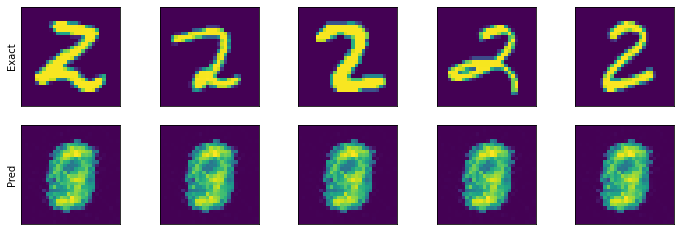

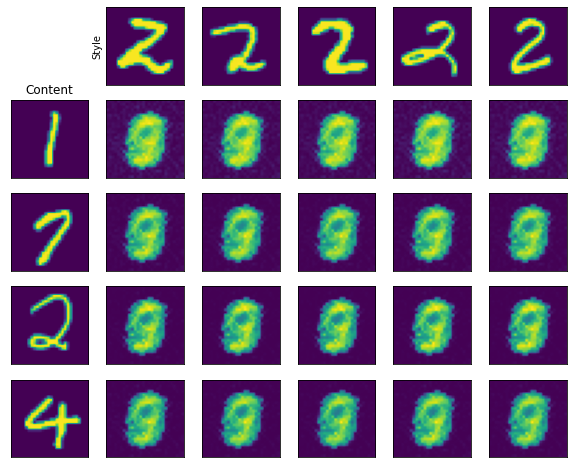

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
	mean loss    = 2014.385
epoch = 13.19s
Start of epoch 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
	mean loss    = 1111.407
epoch = 0.79s
Start of epoch 2
	mean loss    = 1000.224
epoch = 0.83s
Start of epoch 3
	mean loss    = 929.396
epoch = 1.04s
Start of epoch 4
	mean loss    = 889.476
epoch = 1.08s
Start of epoch 5
=== TRN ===


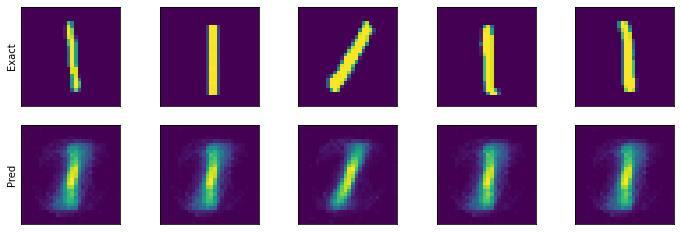

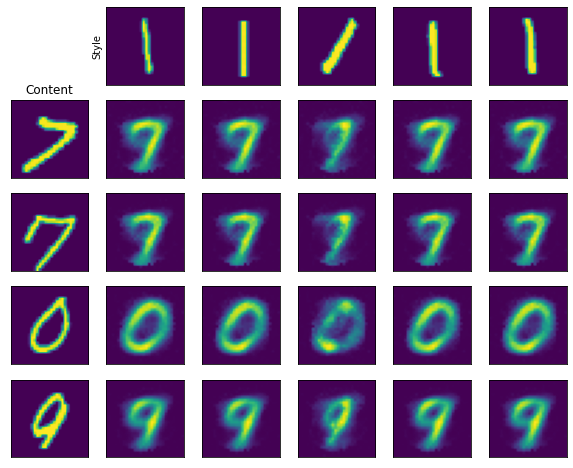

	mean loss    = 857.443
epoch = 3.06s
Start of epoch 6
	mean loss    = 831.994
epoch = 1.03s
Start of epoch 7
	mean loss    = 814.028
epoch = 1.00s
Start of epoch 8
	mean loss    = 801.829
epoch = 1.05s
Start of epoch 9
	mean loss    = 793.693
epoch = 0.81s
Start of epoch 10
=== TRN ===


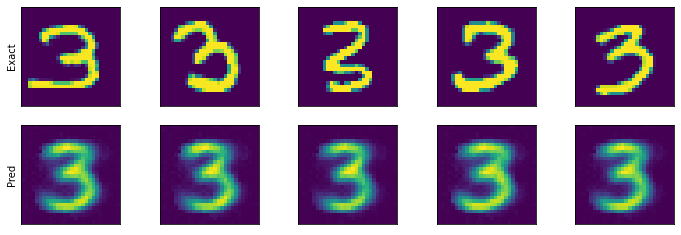

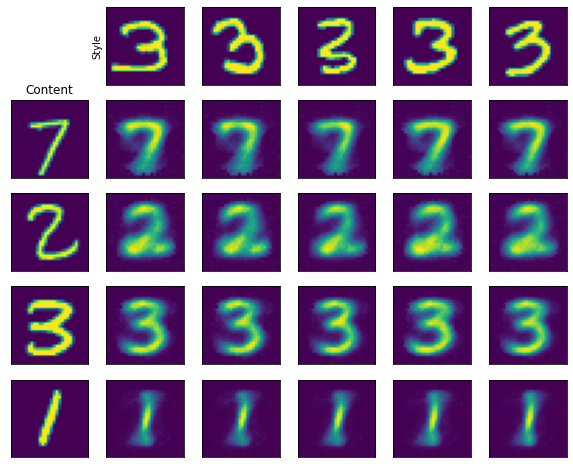

	mean loss    = 787.572
epoch = 2.67s
Start of epoch 11
	mean loss    = 782.728
epoch = 1.04s
Start of epoch 12
	mean loss    = 776.792
epoch = 1.06s
Start of epoch 13
	mean loss    = 772.883
epoch = 1.05s
Start of epoch 14
	mean loss    = 769.483
epoch = 1.06s
Start of epoch 15
=== TRN ===


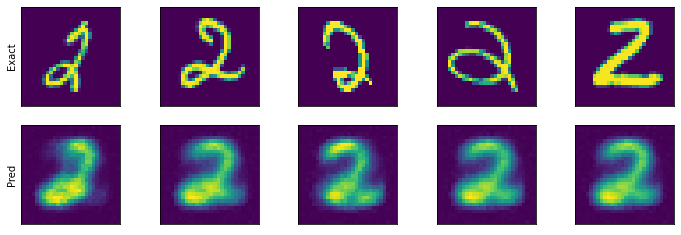

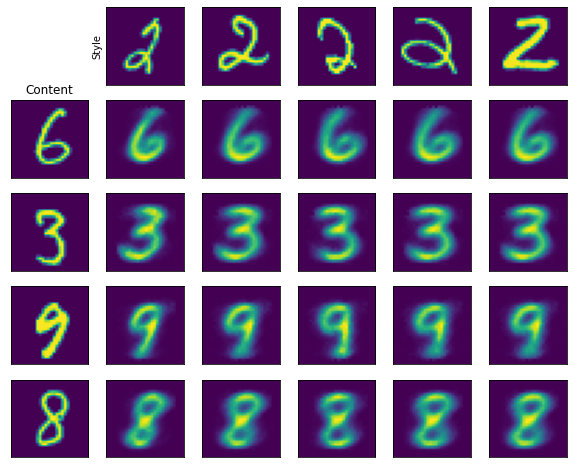

	mean loss    = 766.031
epoch = 3.06s
Start of epoch 16
	mean loss    = 762.481
epoch = 0.81s
Start of epoch 17
	mean loss    = 758.293
epoch = 0.88s
Start of epoch 18
	mean loss    = 756.016
epoch = 0.84s
Start of epoch 19
	mean loss    = 753.237
epoch = 1.07s
Start of epoch 20
=== TRN ===


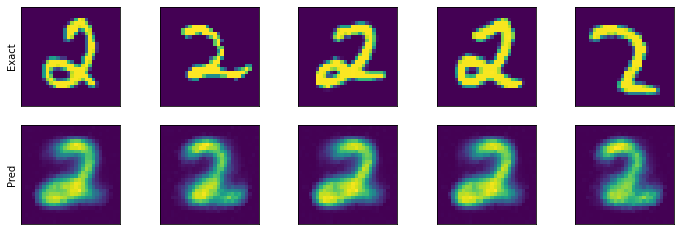

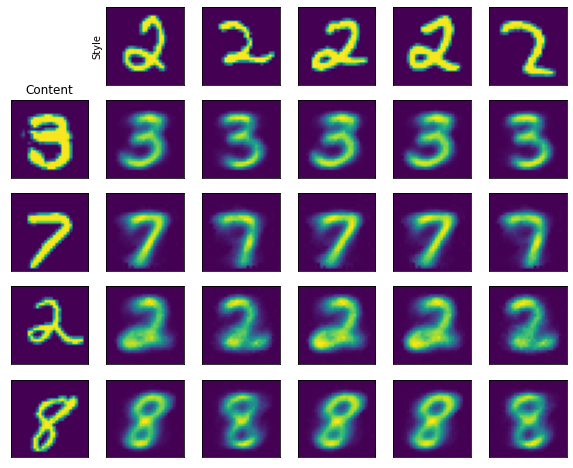

	mean loss    = 750.208
epoch = 2.99s
Start of epoch 21
	mean loss    = 748.536
epoch = 1.00s
Start of epoch 22
	mean loss    = 745.604
epoch = 1.03s
Start of epoch 23
	mean loss    = 743.754
epoch = 1.03s
Start of epoch 24
	mean loss    = 741.492
epoch = 1.04s
Start of epoch 25
=== TRN ===


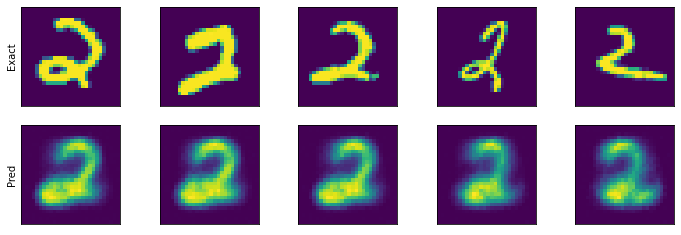

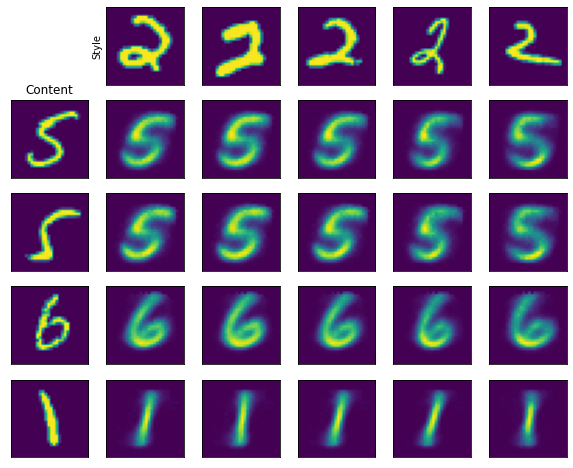

	mean loss    = 739.596
epoch = 2.79s
Start of epoch 26
	mean loss    = 738.368
epoch = 0.96s
Start of epoch 27
	mean loss    = 735.406
epoch = 0.99s
Start of epoch 28
	mean loss    = 733.803
epoch = 0.99s
Start of epoch 29
	mean loss    = 731.796
epoch = 0.97s
Start of epoch 30
=== TRN ===


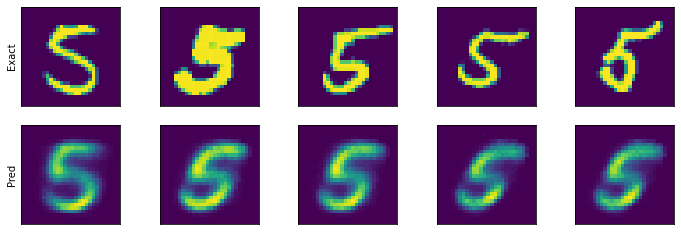

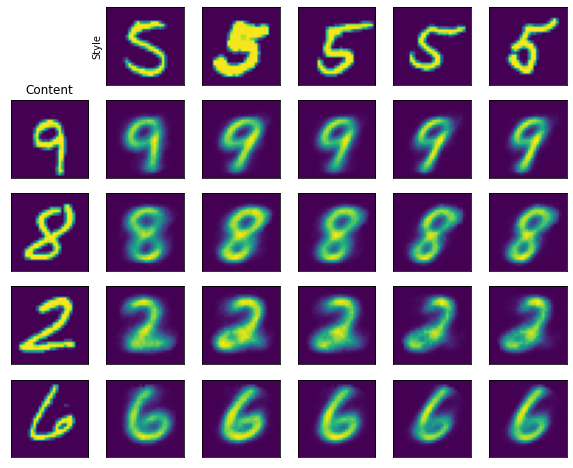

	mean loss    = 731.091
epoch = 2.93s
Start of epoch 31
	mean loss    = 728.899
epoch = 0.95s
Start of epoch 32
	mean loss    = 727.768
epoch = 0.84s
Start of epoch 33
	mean loss    = 725.518
epoch = 0.82s
Start of epoch 34
	mean loss    = 724.047
epoch = 0.80s
Start of epoch 35
=== TRN ===


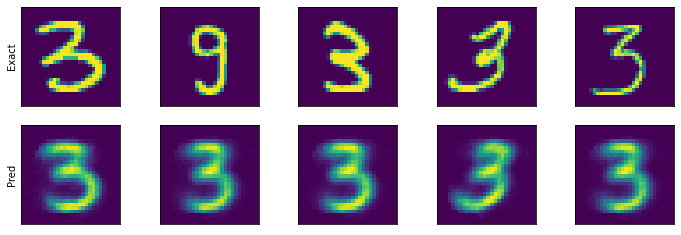

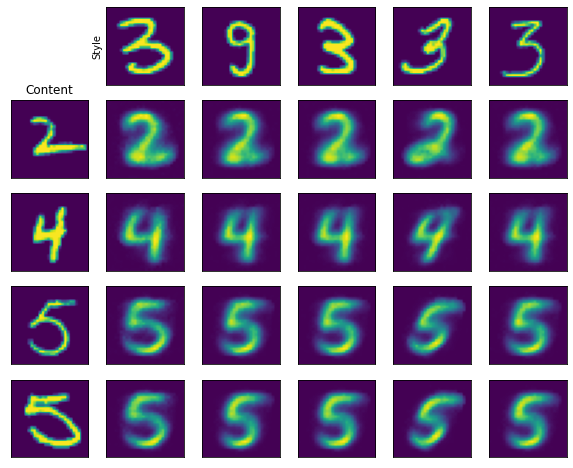

	mean loss    = 723.350
epoch = 2.82s
Start of epoch 36
	mean loss    = 721.949
epoch = 1.08s
Start of epoch 37
	mean loss    = 719.780
epoch = 1.06s
Start of epoch 38
	mean loss    = 718.608
epoch = 1.08s
Start of epoch 39
	mean loss    = 717.949
epoch = 1.05s
Start of epoch 40
=== TRN ===


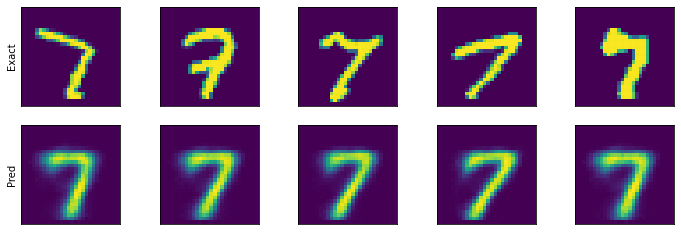

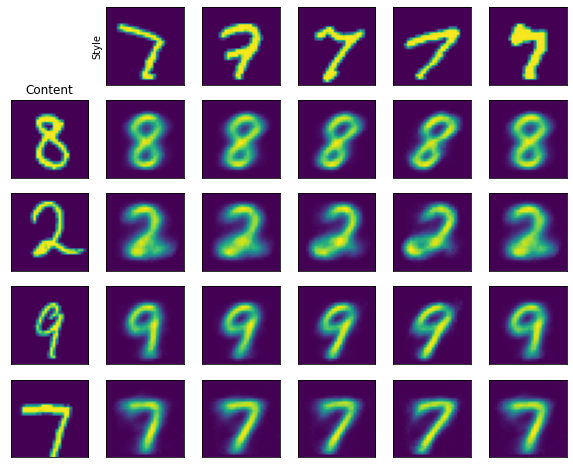

	mean loss    = 716.137
epoch = 3.01s
Start of epoch 41
	mean loss    = 715.530
epoch = 1.05s
Start of epoch 42
	mean loss    = 714.820
epoch = 1.07s
Start of epoch 43
	mean loss    = 713.951
epoch = 1.05s
Start of epoch 44
	mean loss    = 712.948
epoch = 1.04s
Start of epoch 45
=== TRN ===


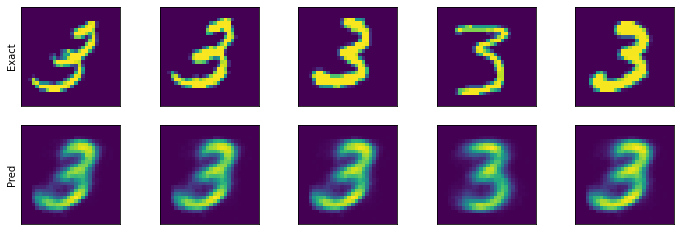

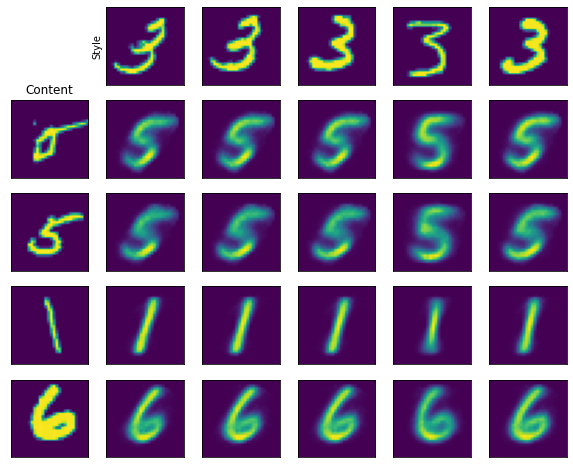

	mean loss    = 711.133
epoch = 2.95s
Start of epoch 46
	mean loss    = 710.978
epoch = 1.05s
Start of epoch 47
	mean loss    = 710.814
epoch = 0.85s
Start of epoch 48
	mean loss    = 710.292
epoch = 0.80s
Start of epoch 49
	mean loss    = 708.323
epoch = 0.84s
Start of epoch 50
=== TRN ===


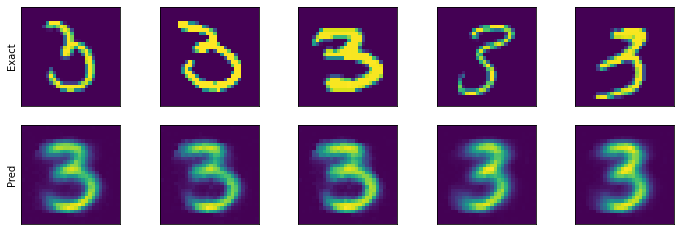

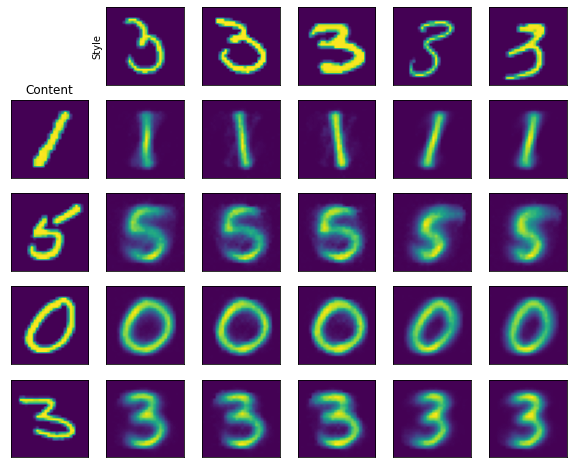

	mean loss    = 709.043
epoch = 2.98s
Start of epoch 51
	mean loss    = 706.415
epoch = 1.04s
Start of epoch 52
	mean loss    = 705.721
epoch = 1.04s
Start of epoch 53
	mean loss    = 705.739
epoch = 1.05s
Start of epoch 54
	mean loss    = 705.507
epoch = 1.10s
Start of epoch 55
=== TRN ===


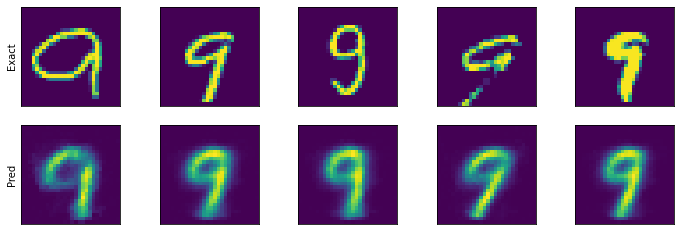

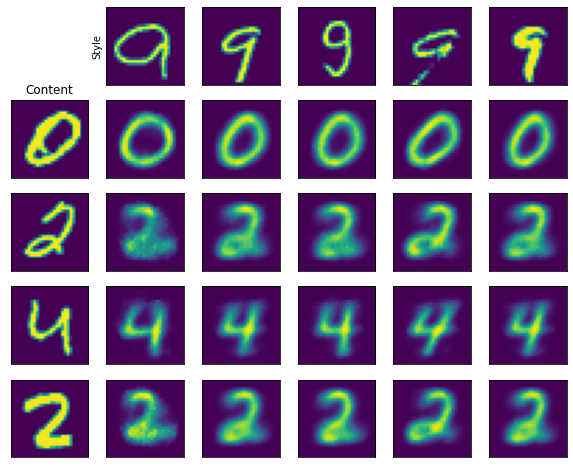

	mean loss    = 705.337
epoch = 2.98s
Start of epoch 56
	mean loss    = 704.472
epoch = 0.88s
Start of epoch 57
	mean loss    = 702.418
epoch = 0.97s
Start of epoch 58
	mean loss    = 702.307
epoch = 0.98s
Start of epoch 59
	mean loss    = 701.844
epoch = 1.03s
Start of epoch 60
=== TRN ===


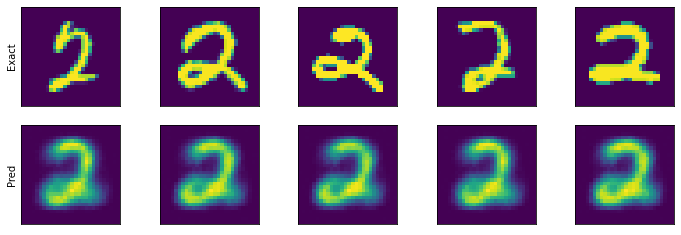

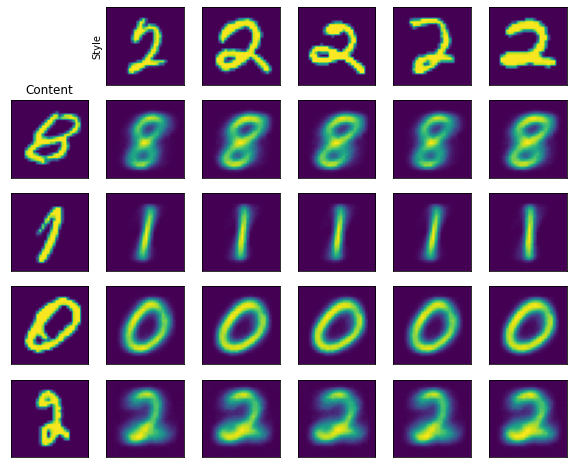

	mean loss    = 700.839
epoch = 2.85s
Start of epoch 61
	mean loss    = 700.885
epoch = 1.01s
Start of epoch 62
	mean loss    = 700.888
epoch = 1.03s
Start of epoch 63
	mean loss    = 701.263
epoch = 0.86s
Start of epoch 64
	mean loss    = 700.523
epoch = 0.86s
Start of epoch 65
=== TRN ===


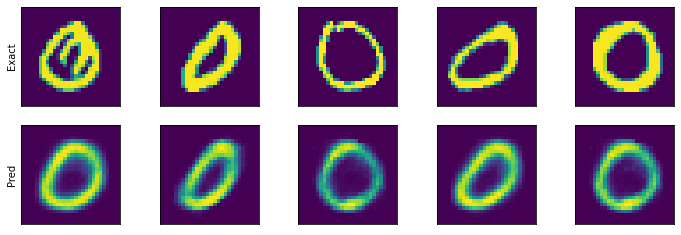

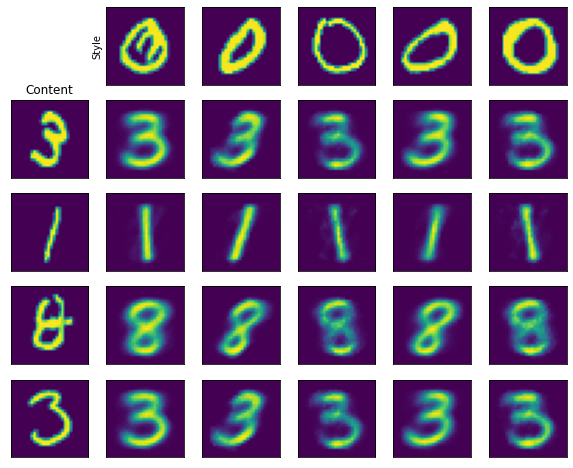

	mean loss    = 698.567
epoch = 2.90s
Start of epoch 66
	mean loss    = 698.926
epoch = 0.99s
Start of epoch 67
	mean loss    = 697.272
epoch = 1.01s
Start of epoch 68
	mean loss    = 697.965
epoch = 1.04s
Start of epoch 69
	mean loss    = 696.283
epoch = 1.05s
Start of epoch 70
=== TRN ===


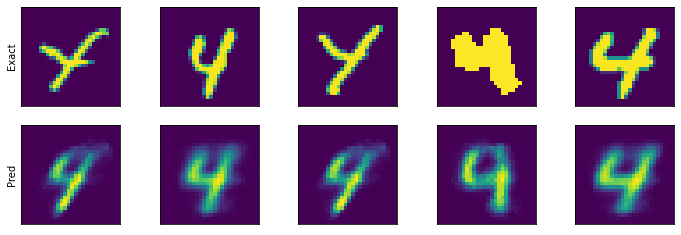

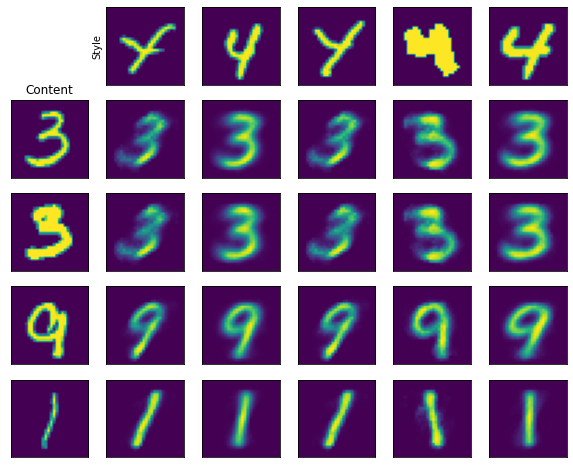

	mean loss    = 697.003
epoch = 2.97s
Start of epoch 71
	mean loss    = 696.693
epoch = 1.05s
Start of epoch 72
	mean loss    = 696.293
epoch = 1.04s
Start of epoch 73
	mean loss    = 695.051
epoch = 0.86s
Start of epoch 74
	mean loss    = 694.688
epoch = 0.79s
Start of epoch 75
=== TRN ===


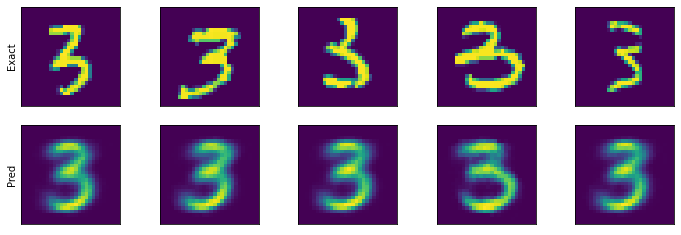

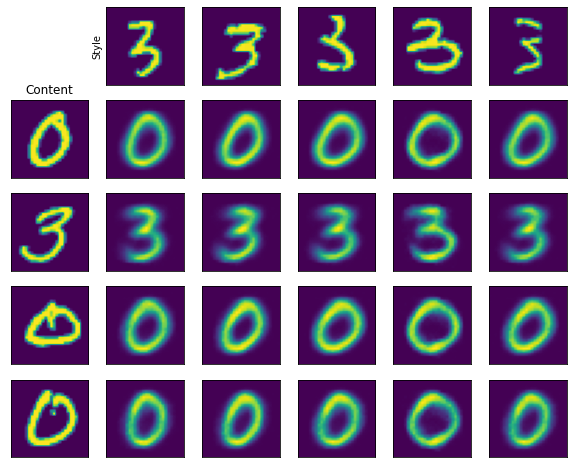

	mean loss    = 695.972
epoch = 2.75s
Start of epoch 76
	mean loss    = 695.231
epoch = 0.99s
Start of epoch 77
	mean loss    = 694.041
epoch = 0.97s
Start of epoch 78
	mean loss    = 693.698
epoch = 1.02s
Start of epoch 79
	mean loss    = 693.431
epoch = 1.04s
Start of epoch 80
=== TRN ===


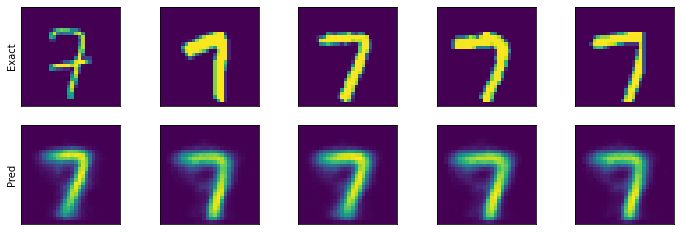

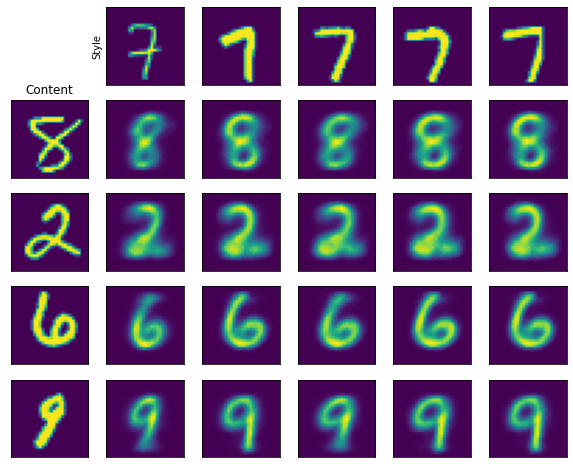

	mean loss    = 692.436
epoch = 3.02s
Start of epoch 81
	mean loss    = 692.896
epoch = 0.83s
Start of epoch 82
	mean loss    = 691.991
epoch = 0.81s
Start of epoch 83
	mean loss    = 692.269
epoch = 0.86s
Start of epoch 84
	mean loss    = 690.645
epoch = 1.03s
Start of epoch 85
=== TRN ===


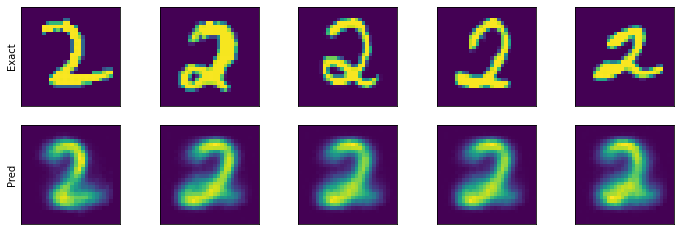

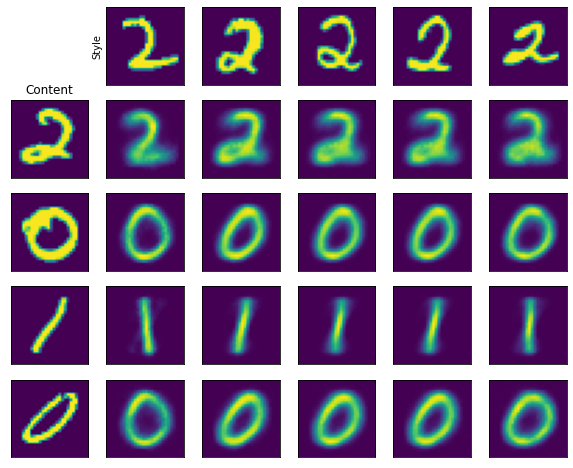

	mean loss    = 690.747
epoch = 2.79s
Start of epoch 86
	mean loss    = 690.903
epoch = 1.03s
Start of epoch 87
	mean loss    = 691.207
epoch = 1.04s
Start of epoch 88
	mean loss    = 689.231
epoch = 1.05s
Start of epoch 89
	mean loss    = 688.867
epoch = 1.06s
Start of epoch 90
=== TRN ===


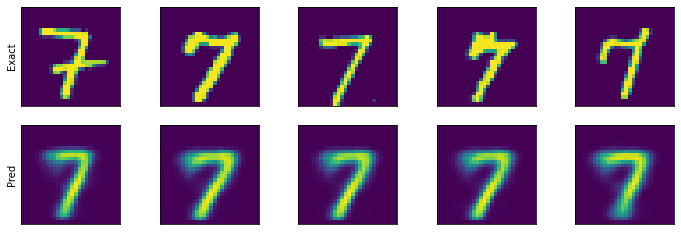

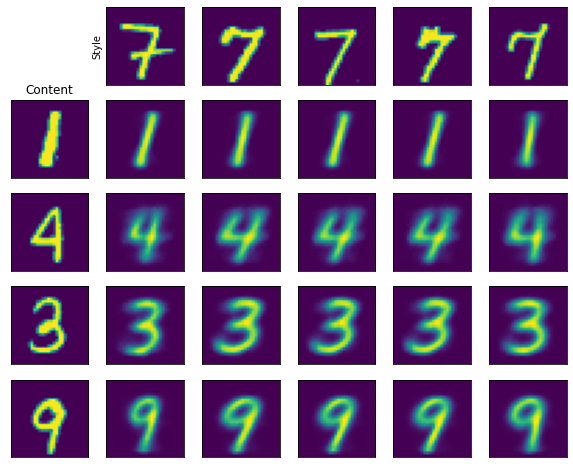

	mean loss    = 689.313
epoch = 2.75s
Start of epoch 91
	mean loss    = 688.768
epoch = 1.01s
Start of epoch 92
	mean loss    = 689.249
epoch = 0.98s
Start of epoch 93
	mean loss    = 687.305
epoch = 1.01s
Start of epoch 94
	mean loss    = 686.953
epoch = 0.99s
Start of epoch 95
=== TRN ===


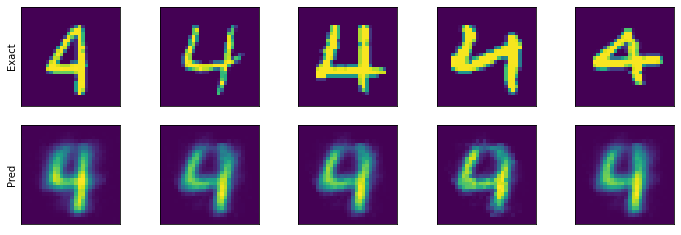

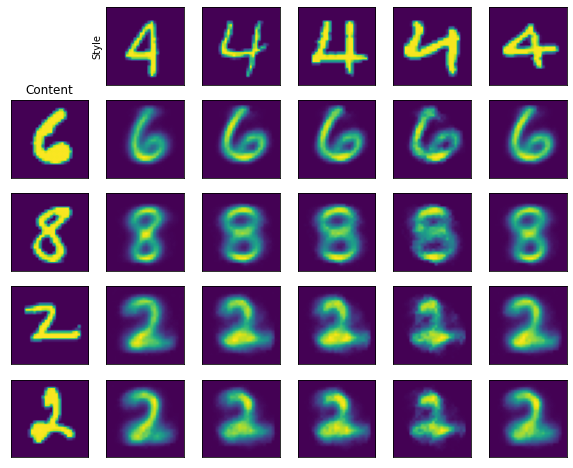

	mean loss    = 687.321
epoch = 2.96s
Start of epoch 96
	mean loss    = 687.500
epoch = 0.95s
Start of epoch 97
	mean loss    = 685.880
epoch = 0.86s
Start of epoch 98
	mean loss    = 686.928
epoch = 0.85s
Start of epoch 99
	mean loss    = 686.006
epoch = 0.88s
Start of epoch 100
=== TRN ===


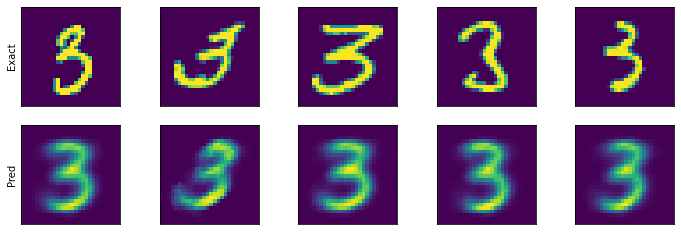

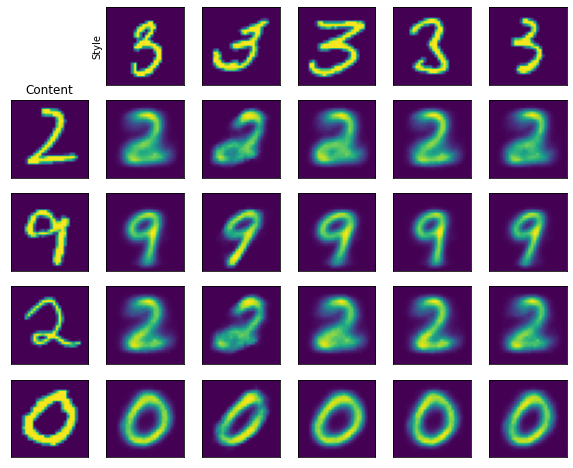

	mean loss    = 686.620
epoch = 2.93s


In [8]:
# Iterate over epochs.
num_epochs = 101

for epoch in range(num_epochs):
#     display.clear_output(wait=False)
    print('===================', flush=True)
    print('Start of epoch %d' % (epoch,))
    start_time = time.perf_counter()
         
    for step, trn_batch in enumerate(trn_dist_dataset):
        _ = distributed_train_step(trn_batch)
            
    if epoch % 5 == 0:
        print('=== TRN ===')
#         if strategy.num_replicas_in_sync > 1:
#             # grab only batch assigned to first GPU
#             trn_batch = [x.values[0].numpy() for x in trn_batch]
#         else:
#             trn_batch = [x.numpy() for x in trn_batch]
#         trn_batch = [x.numpy() for x in trn_batch]
#         trn_batch = trn_batch.numpy()

        trn_batch = trn_batch.values[0].numpy()
    
        """ plot decoding of replicates """
        pred = symae.encode_decode(trn_batch)
#         se = (pred - trn_batch[0])**2 # squared error
        
        pred = pred.numpy()
        
        plt.figure(figsize=(12,4), facecolor='w')
        num_instance_plot = min([5, NUM_INSTANCES])
        for kk in np.arange(num_instance_plot):
            plt.subplot(2, num_instance_plot, kk+1)
            plt.imshow(trn_batch[0,kk,:].reshape(28,28))
            plt.xticks([]); plt.yticks([]);
            if kk == 0:
                plt.ylabel('Exact')
                    
            plt.subplot(2, num_instance_plot, num_instance_plot+kk+1)
            plt.imshow(pred[0,kk,:].reshape(28,28))
            plt.xticks([]); plt.yticks([]);
            if kk == 0:
                plt.ylabel('Pred')
            
        plt.show()
        
        """ plot styling of replicates """
        nsplot = 5 # number of style plots

        content_code = symae.content_encode(trn_batch).numpy()
        style_code = symae.style_encode(trn_batch).numpy()
        
        plt.figure(figsize=(10,10), facecolor='w')
        for jj in np.arange(nsplot):
            styled_mean = symae.style_decode(content_code[[jj],:,:], style_code[[0],:,:])
            styled_mean = styled_mean.numpy()
            for kk in np.arange(nsplot):
                if jj == 0:
                    # plot the style of each instance inside the 0th bag
                    plt.subplot(nsplot+1, nsplot+1, kk+2)
                    plt.imshow(trn_batch[0,kk,:].reshape(28,28))
                    plt.xticks([]); plt.yticks([]);
                    if kk==0:
                        plt.ylabel('Style')
                else:
                    if kk==0:
                        # plot an instance to show the "content"
                        plt.subplot(nsplot+1, nsplot+1, jj*(nsplot+1)+kk+1)
                        plt.imshow(trn_batch[jj,0,:].reshape(28,28))
                        plt.xticks([]); plt.yticks([]);
                        if jj == 1:
                            plt.title('Content')

                    # style the jth bag with styles from the 0th bag
                    plt.subplot(nsplot+1, nsplot+1, jj*(nsplot+1)+kk+2)
                    plt.imshow(styled_mean[0,kk,:].reshape(28,28))
                    plt.xticks([]); plt.yticks([]);
                    
        plt.show()
                
    print('\tmean loss    = %.3f' % trn_loss_metric.result().numpy())
    trn_loss_metric.reset_states()
    
    print('epoch = %.2fs' % (time.perf_counter()-start_time))